In [17]:
import json
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [18]:
# Nouveaux exemples - Clément, le 12 Septembre 2018
list_files_example = os.listdir("data_example/HrvData/")
if ".DS_Store" in list_files_example:
    list_files_example.remove(".DS_Store")

# Anciens exemples - envoyés par Laurent, fin juillet
list_files_example += os.listdir("data_example/")
if ".DS_Store" in list_files_example:
    list_files_example.remove(".DS_Store")
if "HrvData" in list_files_example:
    list_files_example.remove("HrvData")
if "ex_testdata" in list_files_example:
    list_files_example.remove("ex_testdata")
    
data_list = {}

for i, file in enumerate(list_files_example):
    try:
        with open("data_example/" + file) as f:
            data_list[i] = json.load(f)
    except:
        with open("data_example/HrvData/" + file) as f:
            data_list[i] = json.load(f)

In [19]:
def transform_json_data_RrInterval_to_dataframe(json_data):
    data_field = json_data["data"]
    # Split fields in timestamp & value
    df_exploration = pd.DataFrame(list(map(lambda x: x.split(" "), data_field)), 
                                  columns= ["timestamp", "RrInterval"])

    # Cast value as int
    df_exploration["RrInterval"] = df_exploration["RrInterval"].apply(lambda x : int(x))

    # set cleaned timestamp as index
    df_exploration["timestamp"] = pd.to_datetime(df_exploration["timestamp"])
    df_exploration = df_exploration.set_index("timestamp")

    return df_exploration

## Exploration de la cohérence des données extraites

In [21]:
df_list = []
for i in range(len(data_list)):
    try:
        print()
        print("fichier {} : {}".format(i, list_files_example[i]))
        df = transform_json_data_RrInterval_to_dataframe(data_list[i])
        df_list.append(df)
        print("Somme des RrInt (s): " + str(df["RrInterval"].sum() / 1000))
        print("Nombre de RrInt : " + str(df["RrInterval"].count()))
        timedelta = df.index[-1] - df.index[0]
        print("TimeDelta : " + str(timedelta))
        print("En secondes : " + str(timedelta.seconds))
        print(df.resample("1T").count())
        print()
        print("------------------------------------")
    except:
        print("Problem for " + "data_list[" + str(i) + "]")
        print()
        print("------------------------------------")
        pass
    



fichier 0 : e2dcb9bf-31dd-4fe6-b1ca-92b4b9ee834a_RrInterval_2018-09-11T160949.659
Somme des RrInt (s): 819.532
Nombre de RrInt : 1000
TimeDelta : 0 days 00:13:20.989000
En secondes : 800
                     RrInterval
timestamp                      
2018-09-11 16:09:00          14
2018-09-11 16:10:00          73
2018-09-11 16:11:00          73
2018-09-11 16:12:00          73
2018-09-11 16:13:00          77
2018-09-11 16:14:00          89
2018-09-11 16:15:00          81
2018-09-11 16:16:00          75
2018-09-11 16:17:00          74
2018-09-11 16:18:00          73
2018-09-11 16:19:00          74
2018-09-11 16:20:00          70
2018-09-11 16:21:00          70
2018-09-11 16:22:00          72
2018-09-11 16:23:00          12

------------------------------------

fichier 1 : e2dcb9bf-31dd-4fe6-b1ca-92b4b9ee834a_RrInterval_2018-09-11T154255.709
Somme des RrInt (s): 824.81
Nombre de RrInt : 1000
TimeDelta : 0 days 00:13:26
En secondes : 806
                     RrInterval
timestamp         

In [22]:
for i in range(len(data_list)):
    try:
        print()
        print("fichier {}".format(i))
        df = transform_json_data_RrInterval_to_dataframe(data_list[i])
        df = df[:500]
        print("Somme des RrInt (s): " + str(df["RrInterval"].sum() / 1000))
        print("Nombre de RrInt : " + str(df["RrInterval"].count()))
        timedelta = df.index[-1] - df.index[0]
        print("TimeDelta : " + str(timedelta))
        print("En secondes : " + str(timedelta.seconds))
        print(df.resample("1T").count())
        print()
        print("------------------------------------")
    except:
        print("Problem for " + "data_list[" + str(i) + "]")
        print()
        print("------------------------------------")
        pass


fichier 0
Somme des RrInt (s): 395.804
Nombre de RrInt : 500
TimeDelta : 0 days 00:06:25.057000
En secondes : 385
                     RrInterval
timestamp                      
2018-09-11 16:09:00          14
2018-09-11 16:10:00          73
2018-09-11 16:11:00          73
2018-09-11 16:12:00          73
2018-09-11 16:13:00          77
2018-09-11 16:14:00          89
2018-09-11 16:15:00          81
2018-09-11 16:16:00          20

------------------------------------

fichier 1
Somme des RrInt (s): 409.137
Nombre de RrInt : 500
TimeDelta : 0 days 00:06:39.021000
En secondes : 399
                     RrInterval
timestamp                      
2018-09-11 15:42:00           5
2018-09-11 15:43:00          76
2018-09-11 15:44:00          75
2018-09-11 15:45:00          74
2018-09-11 15:46:00          74
2018-09-11 15:47:00          74
2018-09-11 15:48:00          79
2018-09-11 15:49:00          43

------------------------------------

fichier 2
Somme des RrInt (s): 114.123
Nombre de RrIn

# Recherche des points anormaux ou doublons 

In [23]:
df_list[0].head()

,RrInterval
timestamp,
2018-09-11 16:09:49.659,841
2018-09-11 16:09:50.679,828
2018-09-11 16:09:50.679,796
2018-09-11 16:09:51.677,801
2018-09-11 16:09:52.673,789


In [25]:
i = 0
for dataframe in df_list:
    try:
        new_df = dataframe
        # Creation du nouvel index, arrondi au dixième !
        index = list(map(lambda x: pd.to_datetime(str(x)[:-5], 
                                                  format="%Y-%m-%d %H:%M:%S"), new_df.index))
    except:
        index = []
        for tmstp in df_list[3].index:
            try:
                index.append(pd.to_datetime(str(tmstp)[:-5], format="%Y-%m-%d %H:%M:%S"))
            except:
                tmstp = str(tmstp) + ".000"
                index.append(pd.to_datetime(str(tmstp)[:-5], format="%Y-%m-%d %H:%M:%S"))
    
    # 
    new_df.index = index
    index_count = new_df.index.value_counts()

    s = 0
    for val,index in zip(index_count, index_count.index):
        if val >= 2:
            #print(new_df[new_df.index == index])
            if len(set(new_df[new_df.index == index].values.flatten())) == 1:
                s += new_df[new_df.index == index].values.flatten()[0] / 1000
                print(new_df[new_df.index == index])
    print()
    print("s = {}".format(s))
    print("---------------")

                         RrInterval
2018-09-11 16:21:18.400         911
2018-09-11 16:21:18.400         911
2018-09-11 16:21:18.400         911
2018-09-11 16:21:18.400         911
                         RrInterval
2018-09-11 16:18:32.800         884
2018-09-11 16:18:32.800         884
                         RrInterval
2018-09-11 16:16:06.700         809
2018-09-11 16:16:06.700         809
                         RrInterval
2018-09-11 16:17:12.500         756
2018-09-11 16:17:12.500         756
                         RrInterval
2018-09-11 16:11:11.400         854
2018-09-11 16:11:11.400         854
                         RrInterval
2018-09-11 16:17:49.400         802
2018-09-11 16:17:49.400         802
                         RrInterval
2018-09-11 16:11:22.400         792
2018-09-11 16:11:22.400         792
                         RrInterval
2018-09-11 16:21:22.400         916
2018-09-11 16:21:22.400         916
                         RrInterval
2018-09-11 16:15:04.300     

## Visualisation

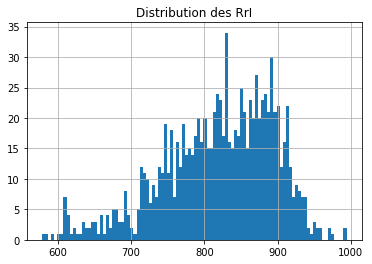

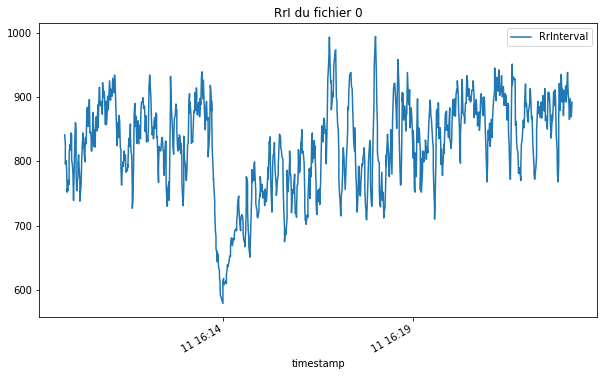

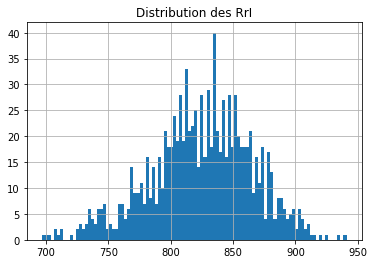

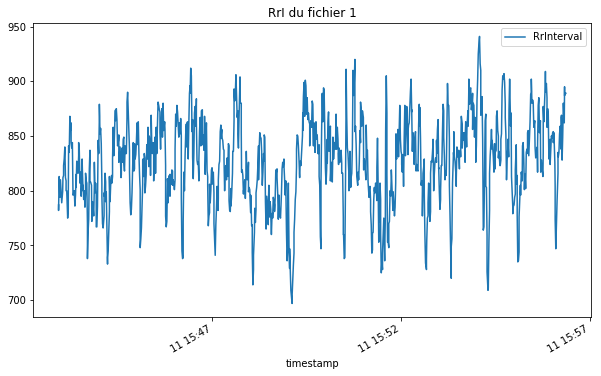

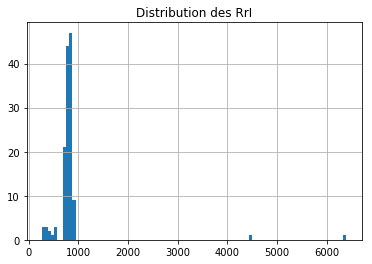

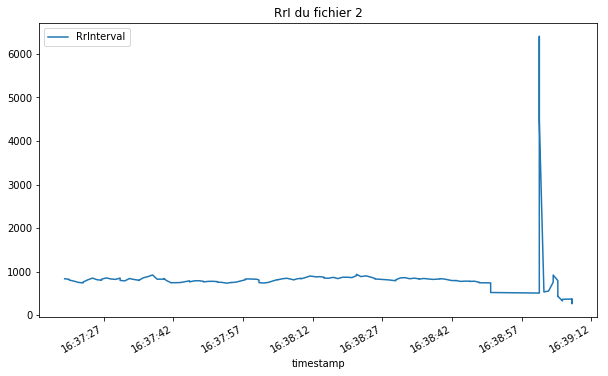

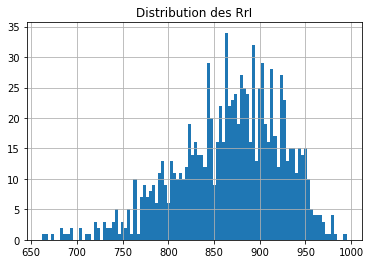

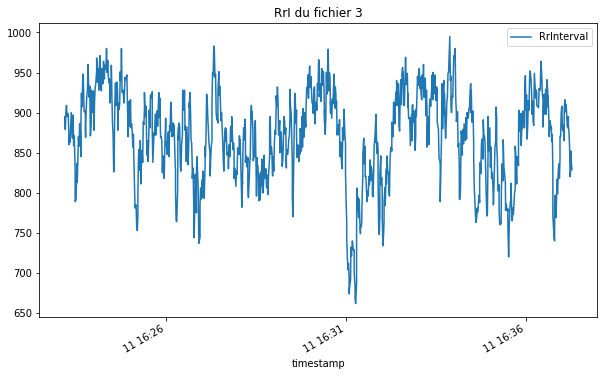

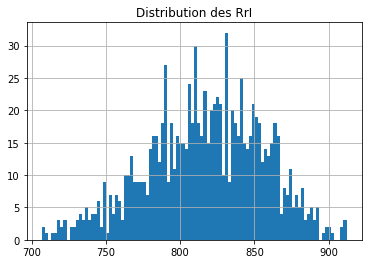

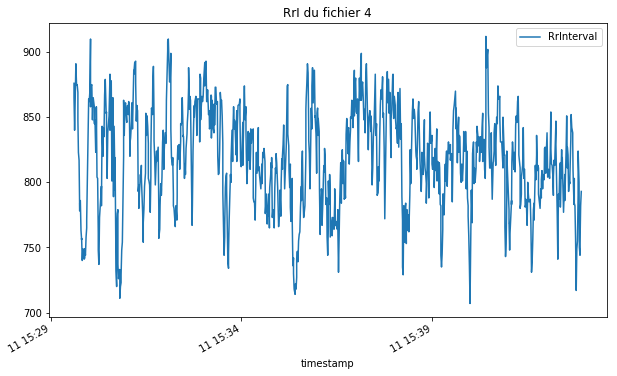

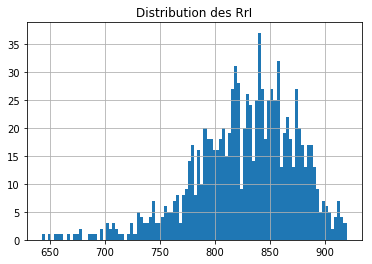

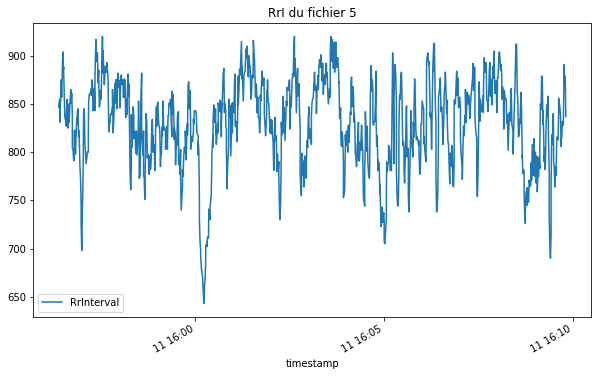

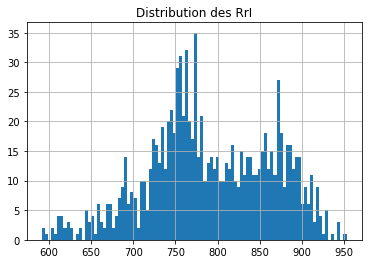

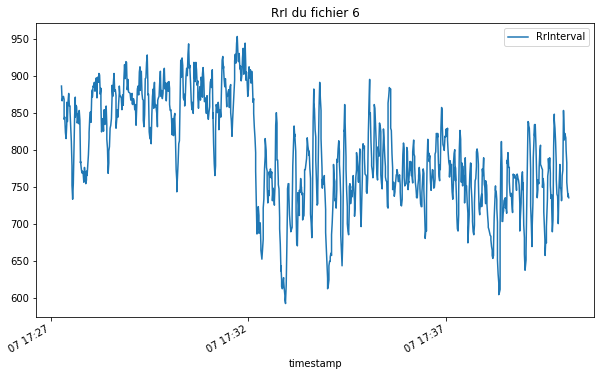

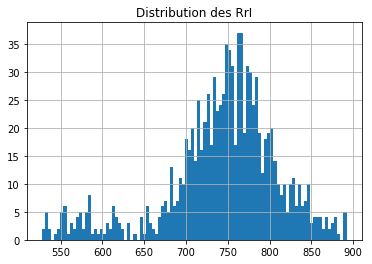

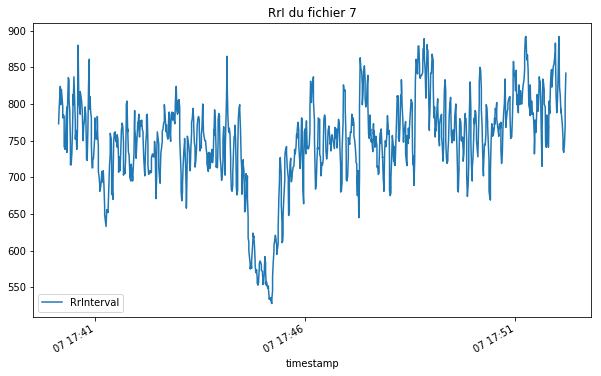

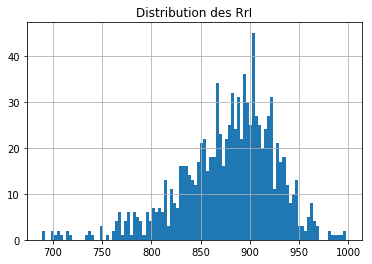

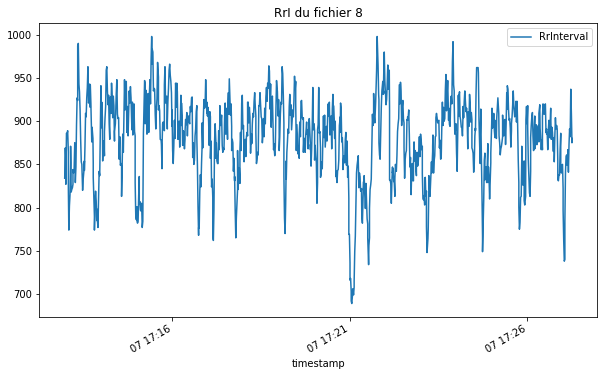

In [8]:
for i in range(len(data_list)):
    try:
        df = transform_json_data_RrInterval_to_dataframe(data_list[i])
        plt.title("Distribution des RrI")
        df["RrInterval"].hist(bins = 100)
        df.plot(figsize=(10, 6), title="RrI du fichier {}".format(i))
        plt.show()
    except:
        raise